In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import shap
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook we will benchmark several models: <br>
Decision trees <br>
Logistic Regression <br>
KNN <br>
XGBoost <br>
Random Forest <br>

We will evaluate them using accuracy score, afterwards we will select the best model and discuss this model in a bit more detail. We will also test the feature importance of the budget of the movie on the best performing model. We did not include this column in the original dataset as this would result in a smaller dataset.

In [43]:
df = pd.read_csv(r"C:\Users\elias\Desktop\HIRB\Liege\Data Management\df_without_budget.csv")
df

,adult,runtime,is_top_actor_movie,lang_ab,lang_af,lang_ar,lang_bg,lang_bm,lang_bn,lang_bo,...,production_country_ZW,production_country_notfound,continent_AF,continent_AS,continent_EU,continent_NA,continent_OC,continent_SA,continent_UNKNOWN,is_top_company_movie
0,False,81.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
1,False,104.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
2,False,101.0,1,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,1
3,False,127.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
4,False,106.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15484,False,45.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,1,0
15485,False,30.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15486,False,85.0,0,False,False,False,False,False,False,False,...,0,0,0,0,0,1,0,0,0,0
15487,False,104.0,0,False,False,False,False,False,False,False,...,0,0,0,0,1,1,0,0,0,0


In [ ]:
df_with_budget = pd.read_csv(r"C:\Users\elias\Desktop\HIRB\Liege\Data Management\df_with_budget.csv")

In [44]:
X = df.drop(['recommend'],axis=1)
X = X.astype('float64')
y = df['recommend']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputing remaining missing values

In [45]:
nulls = pd.DataFrame(df.isnull().sum())
nulls[nulls[0] > 0]

,0
runtime,95
release_year,28
release_month,28
release_dayofweek,28


Runtime --> impute the mean <br>
Year/Month/DayOfWeek --> impute mode

In [46]:
df['release_year'].describe()

count    15461.000000
mean      1997.903370
std         12.987425
min       1888.000000
25%       1995.000000
50%       2001.000000
75%       2005.000000
max       2017.000000
Name: release_year, dtype: float64

In [47]:
def impute_nans(passed_X): 
    passed_X['runtime'].fillna(X_train['runtime'].mean(), inplace=True)
    passed_X['release_year'].fillna(X_train['release_year'].mode().iloc[0].astype(int), inplace=True)
    passed_X['release_month'].fillna(X_train['release_month'].mode().iloc[0].astype(int), inplace=True)
    passed_X['release_dayofweek'].fillna(X_train['release_dayofweek'].mode().iloc[0].astype(int), inplace=True)
    return passed_X

In [48]:
X_train = impute_nans(X_train)
X_test = impute_nans(X_test)

We are dealing with a balanced dataset so no need to take precautions for this.

In [49]:
df['recommend'].value_counts()

recommend
1    7891
0    7598
Name: count, dtype: int64

### DECISION TREE

### LOGISTIC REGRESSION

### k-Nearest Neighbor

### XGBOOST

In the code below we will build an XGBoost model, we will first determine an optimal combination of hyperparameters using Optuna. Afterwards we will evaluate our model using accuracy score. We will also make use of Shapley values in order to get an insight into the feature importance.

Hyperparameter tuning grid is set up in this block

In [50]:
def build_xgb_model(trial):
    
    params = {
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'n_jobs': -1,
        'tree_method': 'hist',
        'random_state': 42,
        'verbosity': 0
    }
    

    
    return xgb.XGBClassifier(**params)

In [53]:
def objective(trial, X_train, y_train, X_val, y_val):
   
    # 1. Build the model with the current trial's hyperparameters
    model = build_xgb_model(trial) 

    # 2. Train the model
    # We use early stopping to prevent overfitting during the trial
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)], # Use logloss as the metric for early stopping
        verbose=False
    )

    # 3. Predict probabilities on the validation set
    # We use predict_proba to get the probabilities required for log_loss
    # We take the probability of the positive class (column 1)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # 4. Calculate the Mean Log Loss
    # This is the value Optuna will try to minimize
    logloss = log_loss(y_val, y_pred_proba)

    return logloss

In [54]:
def train_best_model(X_train, y_train, n_trials=200,):
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(directions=["minimize"])
    
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val), 
        n_trials=n_trials
    )
    
    # Train final models with best parameters
    best_params = study.best_trials[0].params
    
    model_mean = build_xgb_model(
        optuna.trial.FixedTrial(best_params)
        
    ).fit(X, y)
    #Calculate Shapley value to calculate feature importance.
    explainer = shap.Explainer(model_mean, X_train)

    # Calculate SHAP values
    shap_values = explainer(X_val)
    shap.summary_plot(shap_values, features=X_val)
    
    return model_mean, study

## Some Shapley feature importance interpretations
1. Runtime: Longer movies tend to be more often recommended
2. Animation movies and documentaries seem often recommended while horror movies are often not recommended. Family movies seem to slightly push downward the prediction
3. Being a top company movie indeed pushes the prediction upwards.
4. Being an English spoken movie seems to push down the prediction. While Asian movies are slightly more recommended.

 96%|=================== | 2371/2479 [00:14<00:00]       

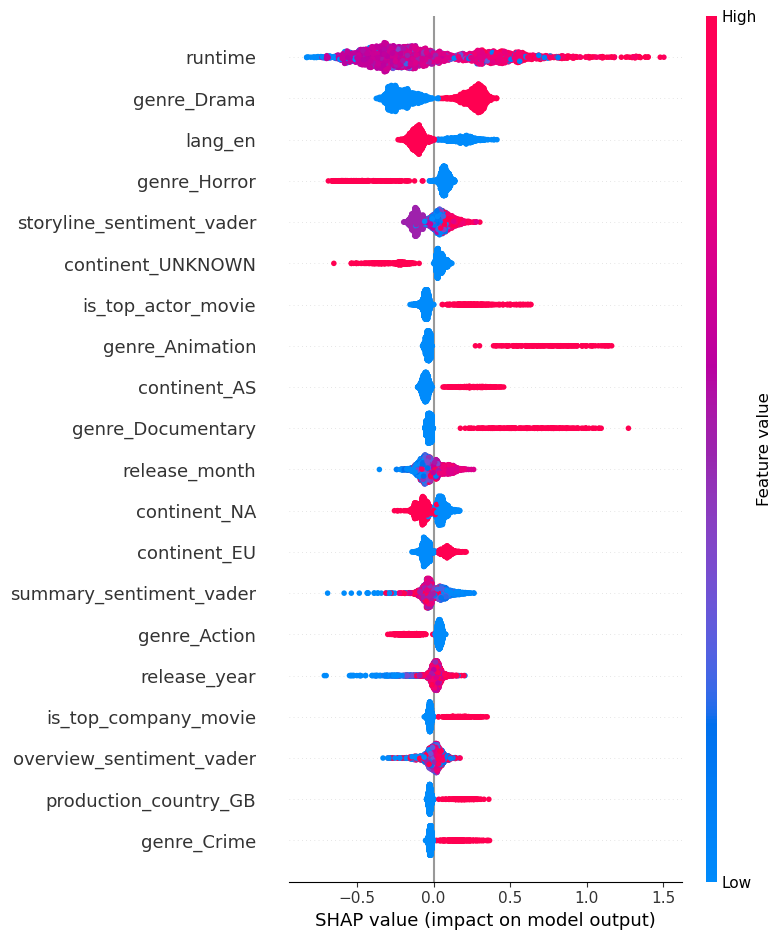

Optimal classifier model is:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7102441180813136, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08910657766073742,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)
The Log Loss of this model is:  0.5980183532992742


In [55]:
model_classifier, study = train_best_model(X_train, y_train, n_trials=50)

# 3. Update the print statements
print("Optimal classifier model is: ", model_classifier)

# 4. Print the correct optimized metric value from the study
# If optimizing for Log Loss (minimization):
print("The Log Loss of this model is: ", study.best_value)

In [56]:
def evaluate_preds(XTest, yTest, Model): 
    y_pred = Model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(yTest, y_pred)

    print("Accuracy: " , accuracy)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        cbar=False,
        # If your labels are multi-class, you should define class labels here
        # xticklabels=opt.classes_, 
        # yticklabels=opt.classes_
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

Accuracy:  0.7336991607488702


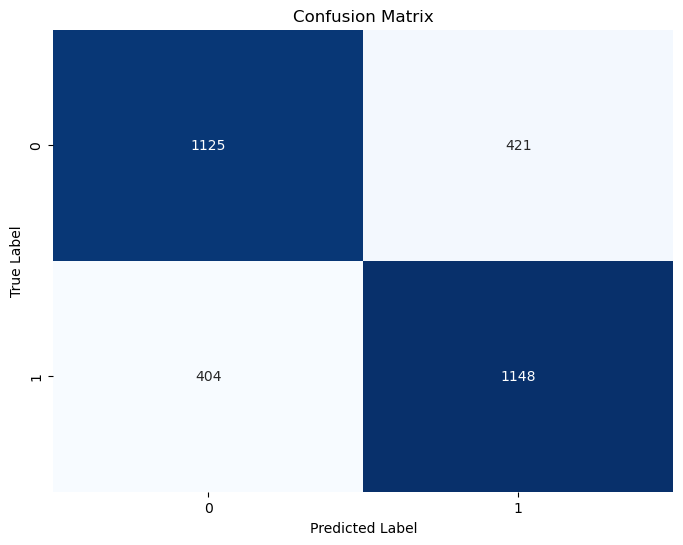

In [57]:
evaluate_preds(X_test, y_test, model_classifier)

### Random Forest Classifier

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_

Accuracy:  0.6750727449078564


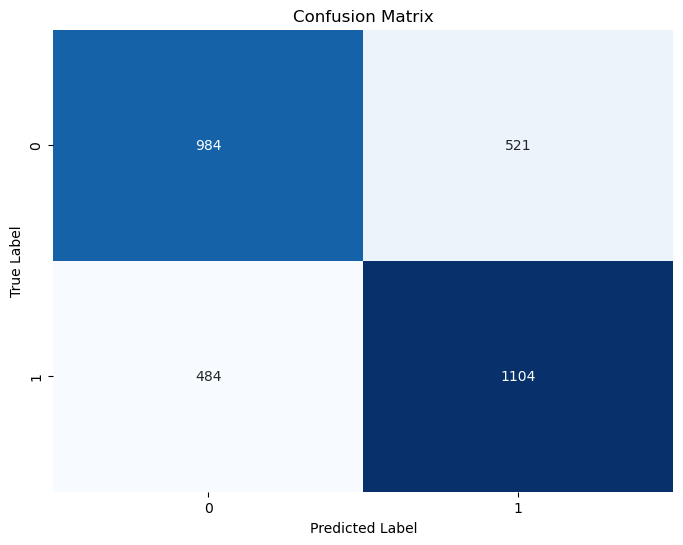

In [ ]:
evaluate_preds(X_test, y_test, model)

Here we will calculate the feature importance using the Gini Coefficient which is a property of decision trees. We see a similar feature importance as for XGBoost with the most important indicator the runtime. However, random forest seems to give a bit more importance to the sentiment feature we engineered. 

In [40]:
feature_names = df.drop("recommend", axis=1).columns.tolist()
importances = model.feature_importances_

feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)[:20]
print(feature_imp_df)


                       Feature  Gini Importance
1                      runtime         0.162887
87                 genre_Drama         0.058081
80   storyline_sentiment_vader         0.058073
78    overview_sentiment_vader         0.056474
79     summary_sentiment_vader         0.055608
101               release_year         0.052925
92                genre_Horror         0.038175
102              release_month         0.037602
86           genre_Documentary         0.029573
103          release_dayofweek         0.028041
18                     lang_en         0.025819
231               continent_EU         0.023623
235          continent_UNKNOWN         0.023069
230               continent_AS         0.021080
83             genre_Animation         0.020958
219      production_country_US         0.014162
232               continent_NA         0.014155
84                genre_Comedy         0.013154
91               genre_History         0.012955
144      production_country_GB         0

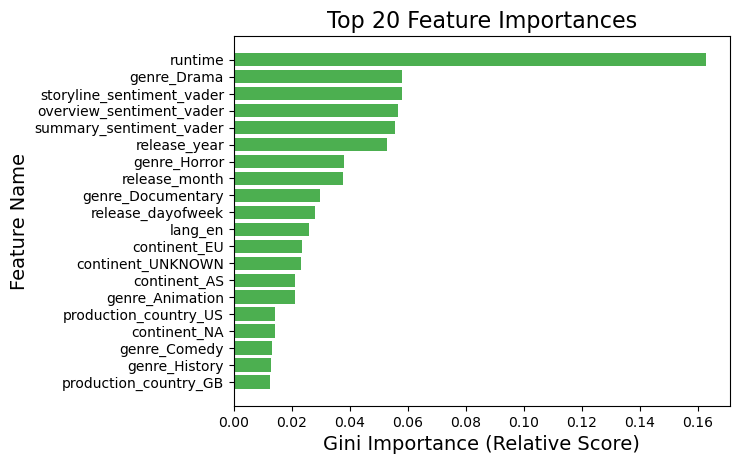

In [42]:
plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='#4CAF50')

plt.xlabel("Gini Importance (Relative Score)", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)
plt.title("Top 20 Feature Importances", fontsize=16)
plt.gca().invert_yaxis()